<a href="https://colab.research.google.com/github/KoYa2003/Financial-Risk-Scoring-Model/blob/main/Financial_Risk_Scoring_Model_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
import pandas as pd



In [4]:
df = pd.read_csv("Loan_default.csv")
df.head()


,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
0,I38PQUQS96,56,85994,50587,520,80,4,15.23,36,0.44,Bachelor's,Full-time,Divorced,Yes,Yes,Other,Yes,0
1,HPSK72WA7R,69,50432,124440,458,15,1,4.81,60,0.68,Master's,Full-time,Married,No,No,Other,Yes,0
2,C1OZ6DPJ8Y,46,84208,129188,451,26,3,21.17,24,0.31,Master's,Unemployed,Divorced,Yes,Yes,Auto,No,1
3,V2KKSFM3UN,32,31713,44799,743,0,3,7.07,24,0.23,High School,Full-time,Married,No,No,Business,No,0
4,EY08JDHTZP,60,20437,9139,633,8,4,6.51,48,0.73,Bachelor's,Unemployed,Divorced,No,Yes,Auto,No,0


In [5]:
df.drop("LoanID", axis=1, inplace=True)


In [6]:
df.isnull().sum()


,0
Age,0
Income,0
LoanAmount,0
CreditScore,0
MonthsEmployed,0
NumCreditLines,0
InterestRate,0
LoanTerm,0
DTIRatio,0
Education,0


In [7]:
df.fillna(df.median(numeric_only=True), inplace=True)
df.fillna(df.mode().iloc[0], inplace=True)


In [8]:
df = pd.get_dummies(df, drop_first=True)


In [9]:
X = df.drop("Default", axis=1)
y = df["Default"]


In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


In [12]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)


In [13]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)


In [14]:
from sklearn.metrics import accuracy_score, classification_report

print(accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))


0.8850979839278161
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     56410
           1       0.61      0.03      0.06      7427

    accuracy                           0.89     63837
   macro avg       0.75      0.52      0.50     63837
weighted avg       0.86      0.89      0.84     63837



In [15]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=150, random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)


In [16]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_test, rf.predict_proba(X_test)[:,1])


np.float64(0.73561516099967)

In [17]:
import pandas as pd

imp = pd.DataFrame({
    "Feature": X.columns,
    "Importance": rf.feature_importances_
}).sort_values(by="Importance", ascending=False)

imp.head(10)


,Feature,Importance
1,Income,0.125897
6,InterestRate,0.119568
2,LoanAmount,0.112835
0,Age,0.103716
3,CreditScore,0.099732
4,MonthsEmployed,0.097416
8,DTIRatio,0.088269
7,LoanTerm,0.040517
5,NumCreditLines,0.031748
17,HasMortgage_Yes,0.015557


**Now, Interpret, validate, and present results**

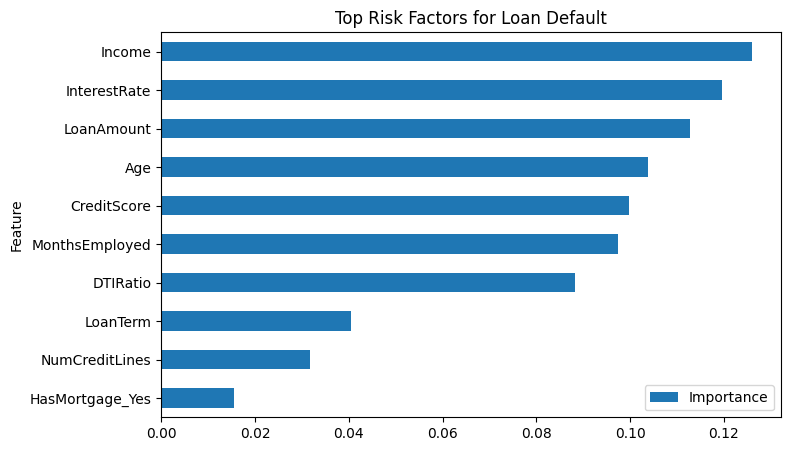

In [21]:
#Visualize Feature Importance
import matplotlib.pyplot as plt

imp.head(10).plot(x="Feature", y="Importance", kind="barh", figsize=(8,5))
plt.title("Top Risk Factors for Loan Default")
plt.gca().invert_yaxis()
plt.show()


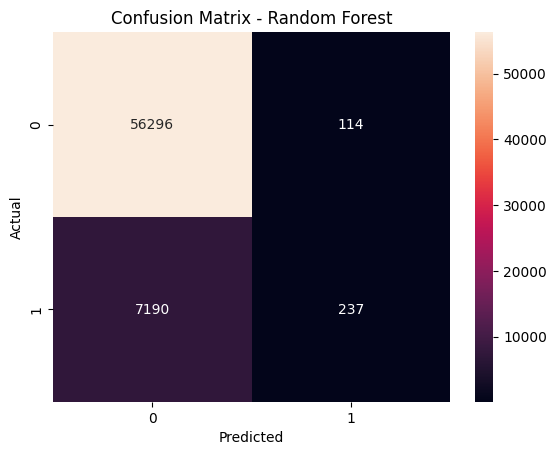

In [20]:
#Confusion Matrix (Model Validation)
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred_rf)

sns.heatmap(cm, annot=True, fmt='d')
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


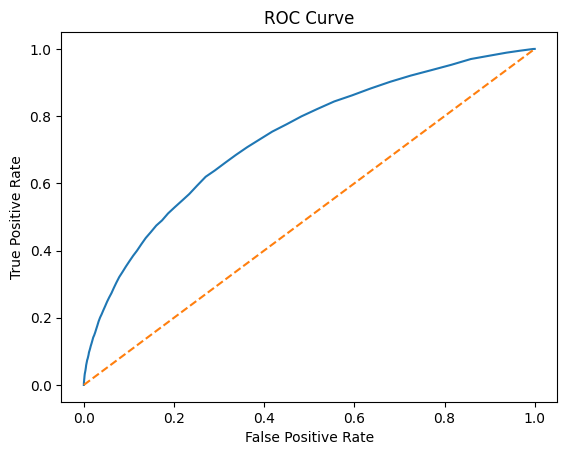

In [22]:
from sklearn.metrics import roc_curve

y_prob = rf.predict_proba(X_test)[:,1]

fpr, tpr, _ = roc_curve(y_test, y_prob)

plt.plot(fpr, tpr)
plt.plot([0,1],[0,1],'--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()


In [23]:
df['RiskScore'] = rf.predict_proba(sc.transform(X))[:,1]
df[['RiskScore','Default']].head()


,RiskScore,Default
0,0.033333,0
1,0.020000,0
2,0.660000,1
3,0.066667,0
4,0.060000,0


**Conclusion:**
The Random Forest model successfully identifies high-risk loan applicants using financial and demographic features. Credit score, DTI ratio, interest rate and employment type were the strongest predictors of default. This model can help banks reduce non-performing assets by improving loan approval decisions.


In [24]:
import joblib
joblib.dump(rf, "loan_risk_model.pkl")
joblib.dump(sc, "scaler.pkl")


['scaler.pkl']